# Calibración de Cámara con Patrón de Tablero de Ajedrez

Este notebook implementa la calibración de cámara utilizando un patrón de tablero de ajedrez. La calibración permite:
- Corregir distorsiones de lente
- Establecer la relación entre coordenadas del mundo real y píxeles
- Obtener parámetros intrínsecos (matriz K, coeficientes de distorsión)

## 1. Importar Librerías Necesarias

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Configuración para mejor visualización
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

print("Librerías importadas correctamente")
print(f"OpenCV version: {cv2.__version__}")

Librerías importadas correctamente
OpenCV version: 4.12.0


## 2. Cargar Imágenes de Calibración

Total de imágenes encontradas: 10

Primeras 5 imágenes:
  1. image_10.jpeg
  2. image_11.jpeg
  3. image_12.jpeg
  4. image_13.jpeg
  5. image_14.jpeg


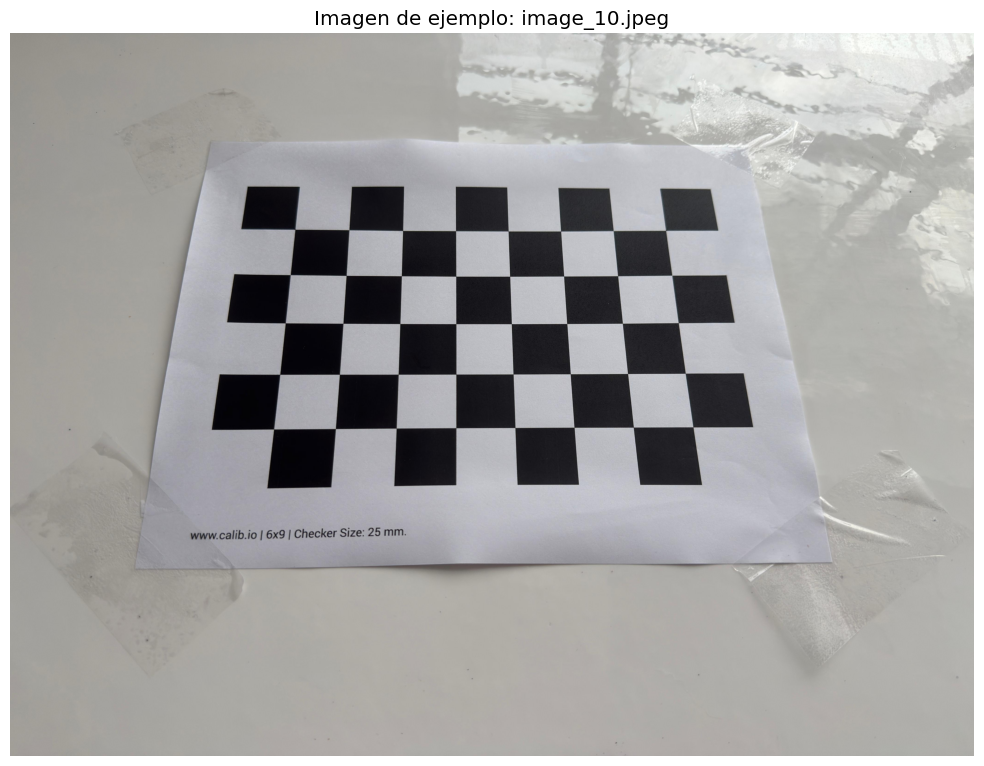


Dimensiones de la imagen: 4160 x 3120 píxeles


In [9]:
# Ruta a las imágenes de calibración
images_path = 'photos/*.jpeg'
images = glob.glob(images_path)
images.sort()

print(f"Total de imágenes encontradas: {len(images)}")
print("\nPrimeras 5 imágenes:")
for i, img_path in enumerate(images[:5]):
    print(f"  {i+1}. {os.path.basename(img_path)}")

# Mostrar una imagen de ejemplo
if len(images) > 0:
    sample_img = cv2.imread(images[0])
    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(sample_img_rgb)
    plt.title(f'Imagen de ejemplo: {os.path.basename(images[0])}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"\nDimensiones de la imagen: {sample_img.shape[1]} x {sample_img.shape[0]} píxeles")
else:
    print("ERROR: No se encontraron imágenes")

## 3. Detectar Esquinas del Tablero de Ajedrez

Vamos a detectar las esquinas internas del patrón de tablero de ajedrez en cada imagen. Necesitamos especificar el tamaño del tablero (número de esquinas internas).

In [10]:
# Definir el tamaño del tablero de ajedrez (esquinas internas)
# IMPORTANTE: Ajustar estos valores según el patrón usado
# Por ejemplo, para un tablero de 9x6 cuadrados, hay 8x5 esquinas internas
CHESSBOARD_SIZE = (8, 5)  # (ancho, alto) en número de esquinas internas

# Preparar puntos del objeto (coordenadas 3D del mundo real)
# Asumimos que el tablero está en el plano Z=0
objp = np.zeros((CHESSBOARD_SIZE[0] * CHESSBOARD_SIZE[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHESSBOARD_SIZE[0], 0:CHESSBOARD_SIZE[1]].T.reshape(-1, 2)

# Arrays para almacenar puntos del objeto y puntos de imagen de todas las imágenes
objpoints = []  # Puntos 3D en el espacio del mundo real
imgpoints = []  # Puntos 2D en el plano de la imagen

# Almacenar imágenes con esquinas detectadas
images_with_corners = []
images_corners_drawn = []

# Criterios de refinamiento de esquinas (sub-pixel)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

print("Procesando imágenes para detectar esquinas del tablero...")
print(f"Buscando patrón de {CHESSBOARD_SIZE[0]}x{CHESSBOARD_SIZE[1]} esquinas internas\n")

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Buscar esquinas del tablero de ajedrez
    ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE, None)
    
    # Si se encuentran las esquinas, agregar puntos del objeto y puntos de imagen
    if ret:
        objpoints.append(objp)
        
        # Refinar la ubicación de las esquinas con precisión sub-pixel
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        
        # Dibujar y mostrar las esquinas
        img_corners = img.copy()
        cv2.drawChessboardCorners(img_corners, CHESSBOARD_SIZE, corners2, ret)
        images_with_corners.append((fname, img_corners))
        
        print(f"✓ {os.path.basename(fname)}: Esquinas detectadas correctamente")
    else:
        print(f"✗ {os.path.basename(fname)}: No se pudieron detectar las esquinas")

print(f"\n{'='*60}")
print(f"Total de imágenes procesadas exitosamente: {len(objpoints)} / {len(images)}")
print(f"{'='*60}")

Procesando imágenes para detectar esquinas del tablero...
Buscando patrón de 8x5 esquinas internas

✓ image_10.jpeg: Esquinas detectadas correctamente
✓ image_11.jpeg: Esquinas detectadas correctamente
✓ image_10.jpeg: Esquinas detectadas correctamente
✓ image_11.jpeg: Esquinas detectadas correctamente
✓ image_12.jpeg: Esquinas detectadas correctamente
✓ image_12.jpeg: Esquinas detectadas correctamente
✓ image_13.jpeg: Esquinas detectadas correctamente
✓ image_13.jpeg: Esquinas detectadas correctamente
✗ image_14.jpeg: No se pudieron detectar las esquinas
✓ image_15.jpeg: Esquinas detectadas correctamente
✗ image_14.jpeg: No se pudieron detectar las esquinas
✓ image_15.jpeg: Esquinas detectadas correctamente
✗ image_16.jpeg: No se pudieron detectar las esquinas
✗ image_16.jpeg: No se pudieron detectar las esquinas
✗ image_17.jpeg: No se pudieron detectar las esquinas
✓ image_18.jpeg: Esquinas detectadas correctamente
✗ image_17.jpeg: No se pudieron detectar las esquinas
✓ image_18.jpeg

## 4. Visualizar Imágenes con Esquinas Detectadas

Mostramos 4-6 imágenes con las esquinas detectadas dibujadas para verificar la calidad de la detección.

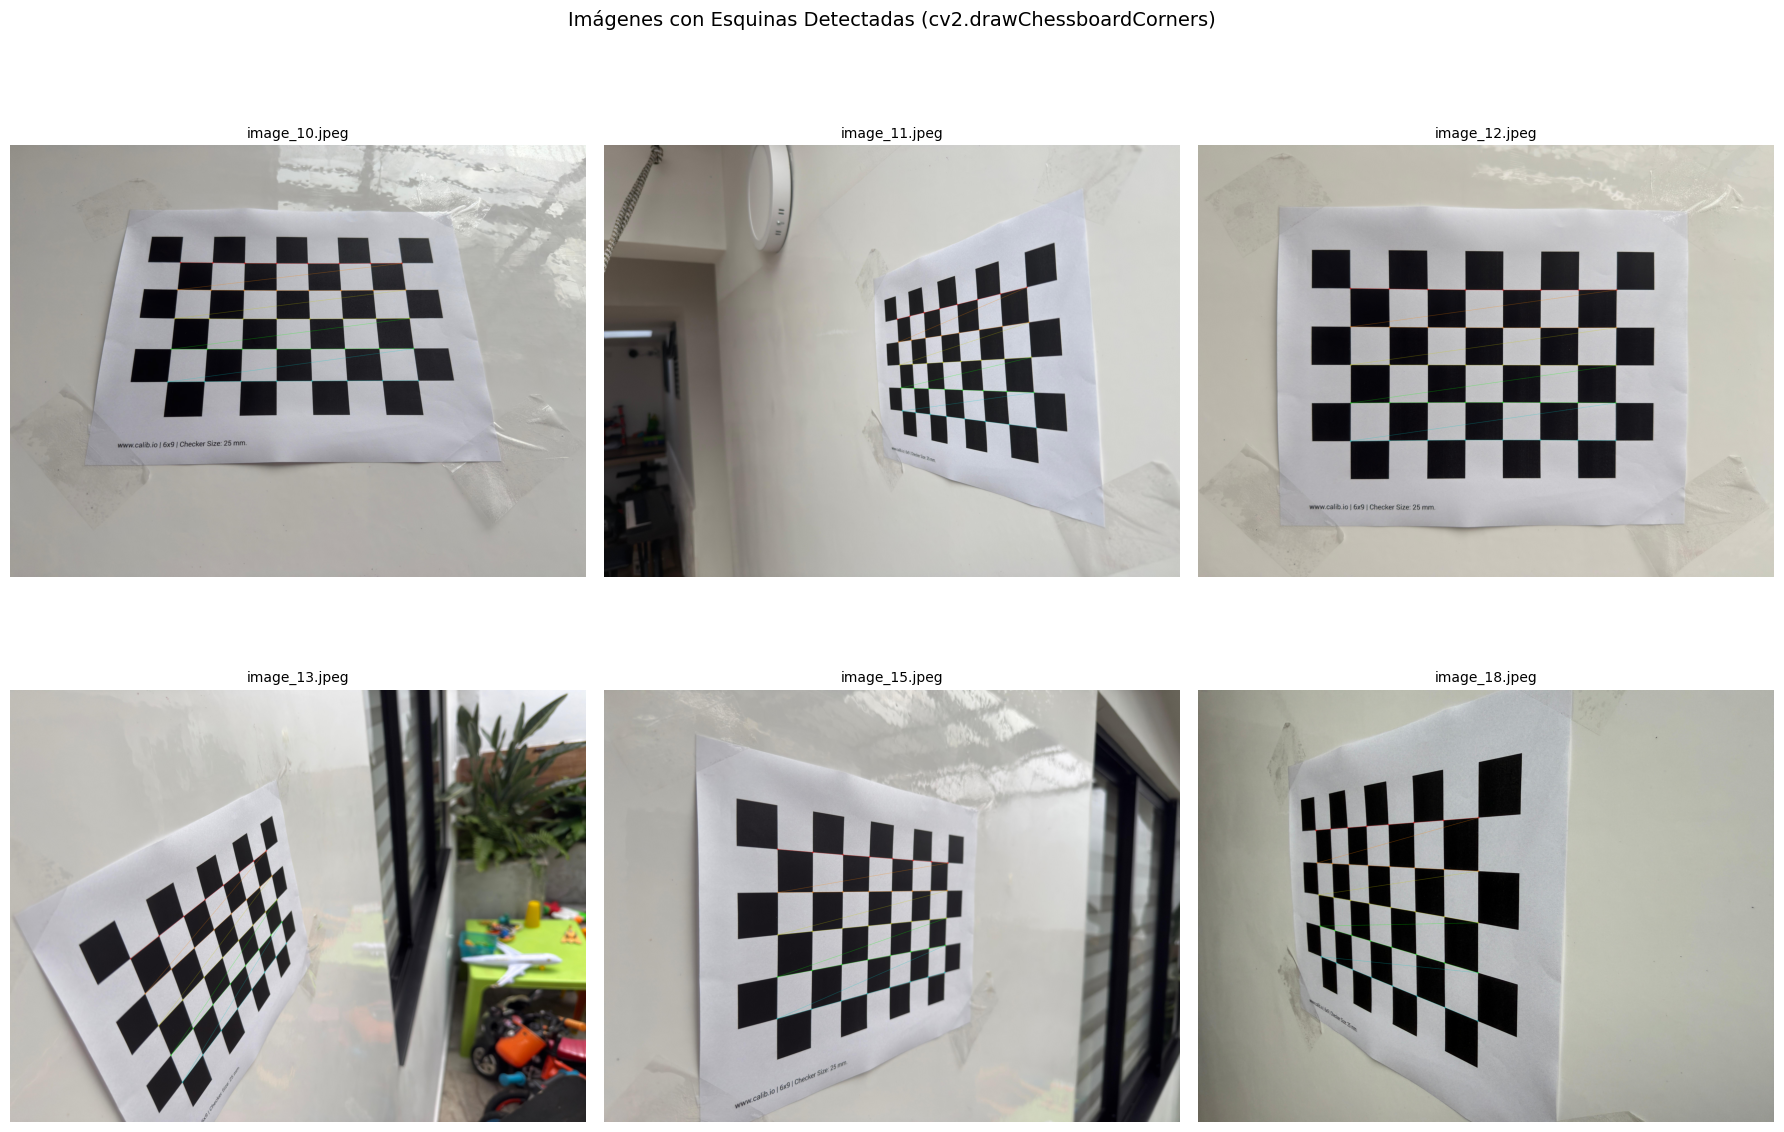

In [11]:
# Mostrar 6 imágenes con esquinas detectadas
num_images_to_show = min(6, len(images_with_corners))

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx in range(num_images_to_show):
    fname, img_corners = images_with_corners[idx]
    img_rgb = cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB)
    
    axes[idx].imshow(img_rgb)
    axes[idx].set_title(f'{os.path.basename(fname)}', fontsize=10)
    axes[idx].axis('off')

# Ocultar ejes vacíos si hay menos de 6 imágenes
for idx in range(num_images_to_show, 6):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Imágenes con Esquinas Detectadas (cv2.drawChessboardCorners)', 
              fontsize=14, y=1.02)
plt.show()

## 5. Realizar Calibración de Cámara

Usamos `cv2.calibrateCamera()` para obtener los parámetros intrínsecos de la cámara.

In [12]:
if len(objpoints) > 0:
    # Obtener dimensiones de la imagen
    img_shape = gray.shape[::-1]
    
    # Calibrar la cámara
    print("Realizando calibración de cámara...")
    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, img_shape, None, None
    )
    
    print("\n" + "="*60)
    print("CALIBRACIÓN COMPLETADA")
    print("="*60)
    
    # Guardar resultados para uso posterior
    calibration_results = {
        'camera_matrix': camera_matrix,
        'dist_coeffs': dist_coeffs,
        'rvecs': rvecs,
        'tvecs': tvecs,
        'rms_error': ret,
        'img_shape': img_shape
    }
else:
    print("ERROR: No se detectaron esquinas en ninguna imagen. Verifica el tamaño del tablero.")

Realizando calibración de cámara...

CALIBRACIÓN COMPLETADA


## 6. Mostrar Resultados de Calibración

### 6.1 Matriz de Cámara K (Parámetros Intrínsecos)

In [13]:
# Extraer parámetros de la matriz de cámara
fx = camera_matrix[0, 0]
fy = camera_matrix[1, 1]
cx = camera_matrix[0, 2]
cy = camera_matrix[1, 2]

print("MATRIZ DE CÁMARA K:")
print("="*60)
print("\nK = ")
print(camera_matrix)
print("\nParámetros individuales:")
print(f"  fx (distancia focal en x) = {fx:.2f} píxeles")
print(f"  fy (distancia focal en y) = {fy:.2f} píxeles")
print(f"  cx (centro óptico en x)   = {cx:.2f} píxeles")
print(f"  cy (centro óptico en y)   = {cy:.2f} píxeles")
print("\n" + "="*60)

MATRIZ DE CÁMARA K:

K = 
[[2.87256908e+03 0.00000000e+00 2.00453439e+03]
 [0.00000000e+00 2.85590006e+03 1.55134820e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Parámetros individuales:
  fx (distancia focal en x) = 2872.57 píxeles
  fy (distancia focal en y) = 2855.90 píxeles
  cx (centro óptico en x)   = 2004.53 píxeles
  cy (centro óptico en y)   = 1551.35 píxeles



### 6.2 Coeficientes de Distorsión

In [14]:
# Extraer coeficientes de distorsión
k1, k2, p1, p2, k3 = dist_coeffs[0]

print("COEFICIENTES DE DISTORSIÓN:")
print("="*60)
print("\nCoeficientes = ", dist_coeffs)
print("\nParámetros individuales:")
print(f"  k1 (distorsión radial)     = {k1:.6f}")
print(f"  k2 (distorsión radial)     = {k2:.6f}")
print(f"  p1 (distorsión tangencial) = {p1:.6f}")
print(f"  p2 (distorsión tangencial) = {p2:.6f}")
print(f"  k3 (distorsión radial)     = {k3:.6f}")
print("\n" + "="*60)

COEFICIENTES DE DISTORSIÓN:

Coeficientes =  [[ 1.77385165e-01 -9.76267009e-01  1.36653770e-03  6.96734092e-04
   1.34304219e+00]]

Parámetros individuales:
  k1 (distorsión radial)     = 0.177385
  k2 (distorsión radial)     = -0.976267
  p1 (distorsión tangencial) = 0.001367
  p2 (distorsión tangencial) = 0.000697
  k3 (distorsión radial)     = 1.343042



### 6.3 Error RMS de Reproyección

In [15]:
print("ERROR RMS DE REPROYECCIÓN:")
print("="*60)
print(f"\nError RMS = {ret:.4f} píxeles")
print("\nInterpretación:")
if ret < 0.5:
    print("  ✓ Excelente calibración (< 0.5 píxeles)")
elif ret < 1.0:
    print("  ✓ Buena calibración (< 1.0 píxel)")
else:
    print("  ⚠ Calibración aceptable pero podría mejorar")
print("\n" + "="*60)

ERROR RMS DE REPROYECCIÓN:

Error RMS = 1.8039 píxeles

Interpretación:
  ⚠ Calibración aceptable pero podría mejorar



## 7. Corrección de Distorsión (Undistort)

Aplicamos la corrección de distorsión a las imágenes usando los parámetros calibrados.

In [16]:
# Seleccionar 3 imágenes para mostrar la corrección
images_to_undistort = images[:3]
undistorted_images = []

for img_path in images_to_undistort:
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    
    # Obtener nueva matriz de cámara óptima
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(
        camera_matrix, dist_coeffs, (w, h), 1, (w, h)
    )
    
    # Corregir distorsión
    dst = cv2.undistort(img, camera_matrix, dist_coeffs, None, newcameramtx)
    
    # Recortar la imagen (opcional)
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    
    undistorted_images.append((img_path, img, dst))

print(f"Se procesaron {len(undistorted_images)} imágenes para corrección de distorsión")

Se procesaron 3 imágenes para corrección de distorsión


## 8. Comparación: Imágenes Originales vs. Corregidas

Mostramos lado a lado las imágenes originales y las corregidas, enfocándonos en las esquinas donde la distorsión es más evidente.

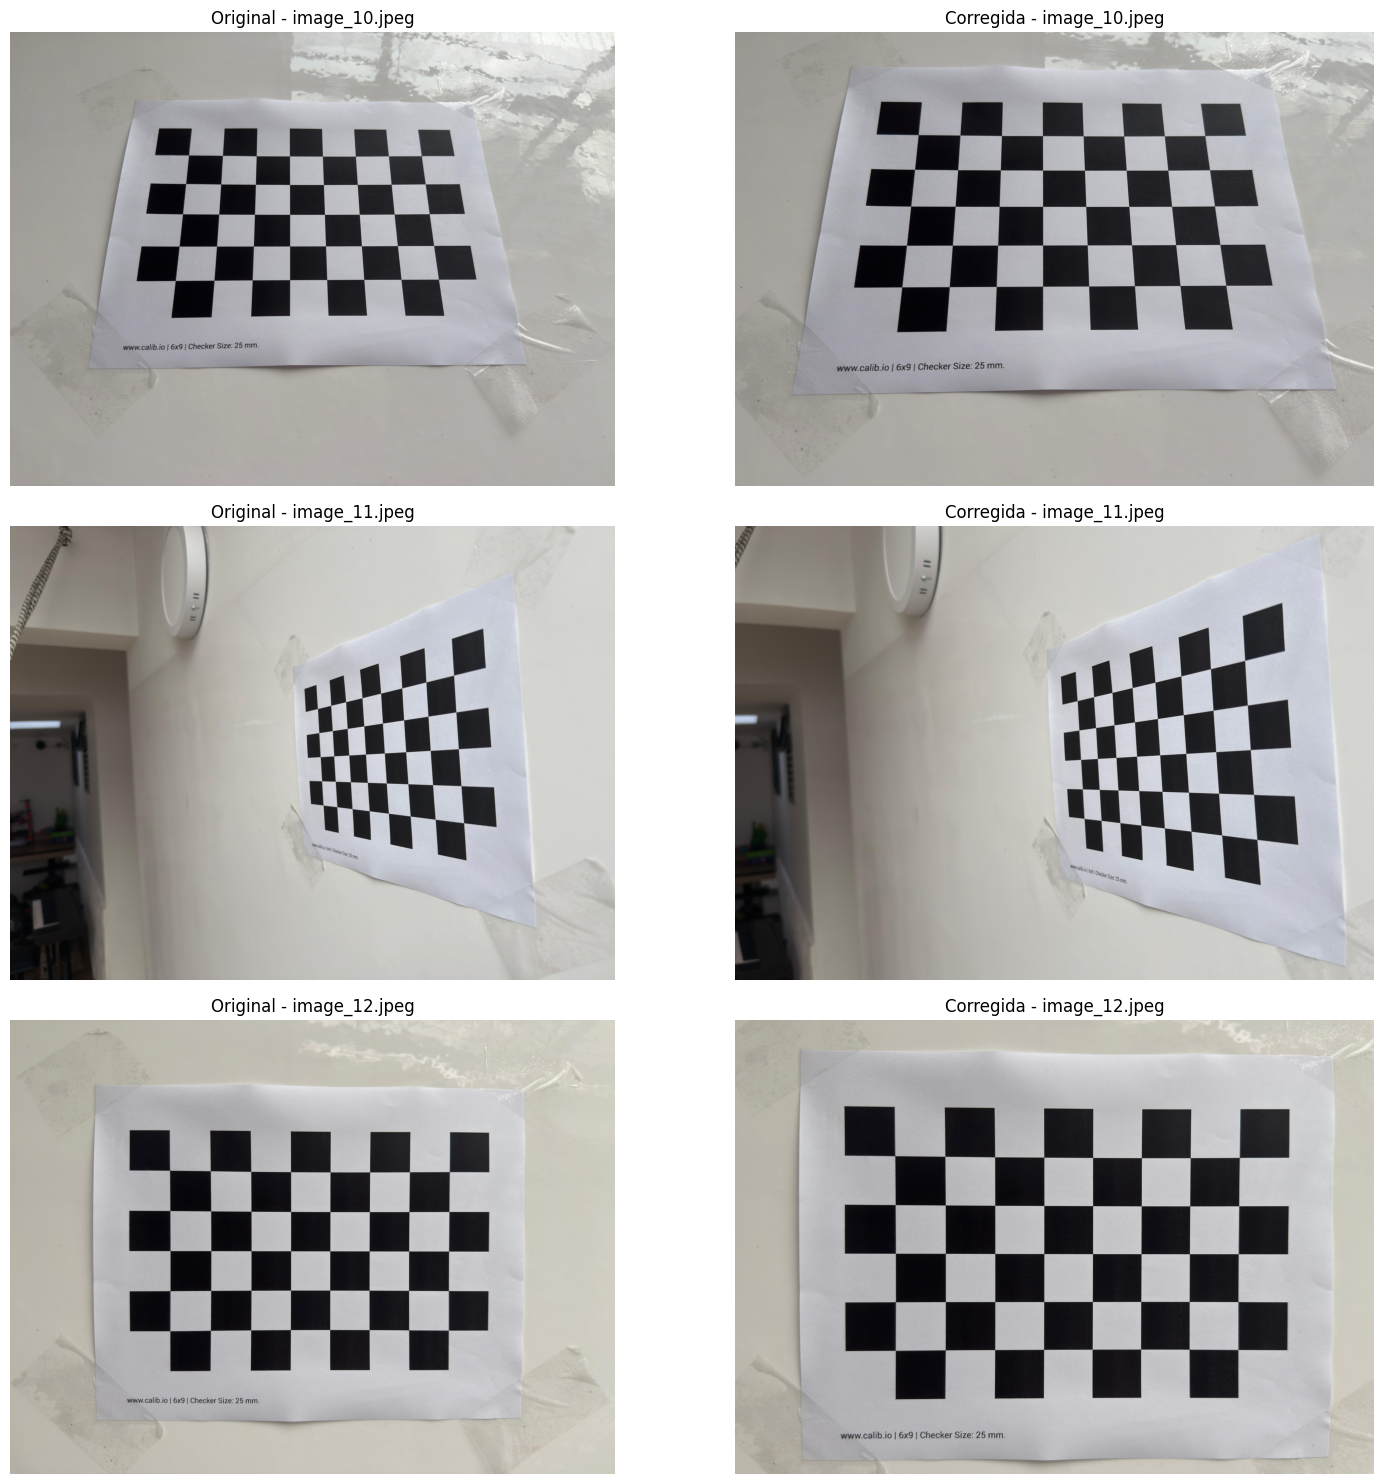

In [17]:
# Mostrar comparación lado a lado
fig, axes = plt.subplots(len(undistorted_images), 2, figsize=(16, 5*len(undistorted_images)))

if len(undistorted_images) == 1:
    axes = axes.reshape(1, -1)

for idx, (img_path, original, undistorted) in enumerate(undistorted_images):
    # Convertir a RGB
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    undistorted_rgb = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)
    
    # Imagen original
    axes[idx, 0].imshow(original_rgb)
    axes[idx, 0].set_title(f'Original - {os.path.basename(img_path)}', fontsize=12)
    axes[idx, 0].axis('off')
    
    # Imagen corregida
    axes[idx, 1].imshow(undistorted_rgb)
    axes[idx, 1].set_title(f'Corregida - {os.path.basename(img_path)}', fontsize=12)
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

### 8.1 Zoom en las Esquinas (Donde la Distorsión es Mayor)

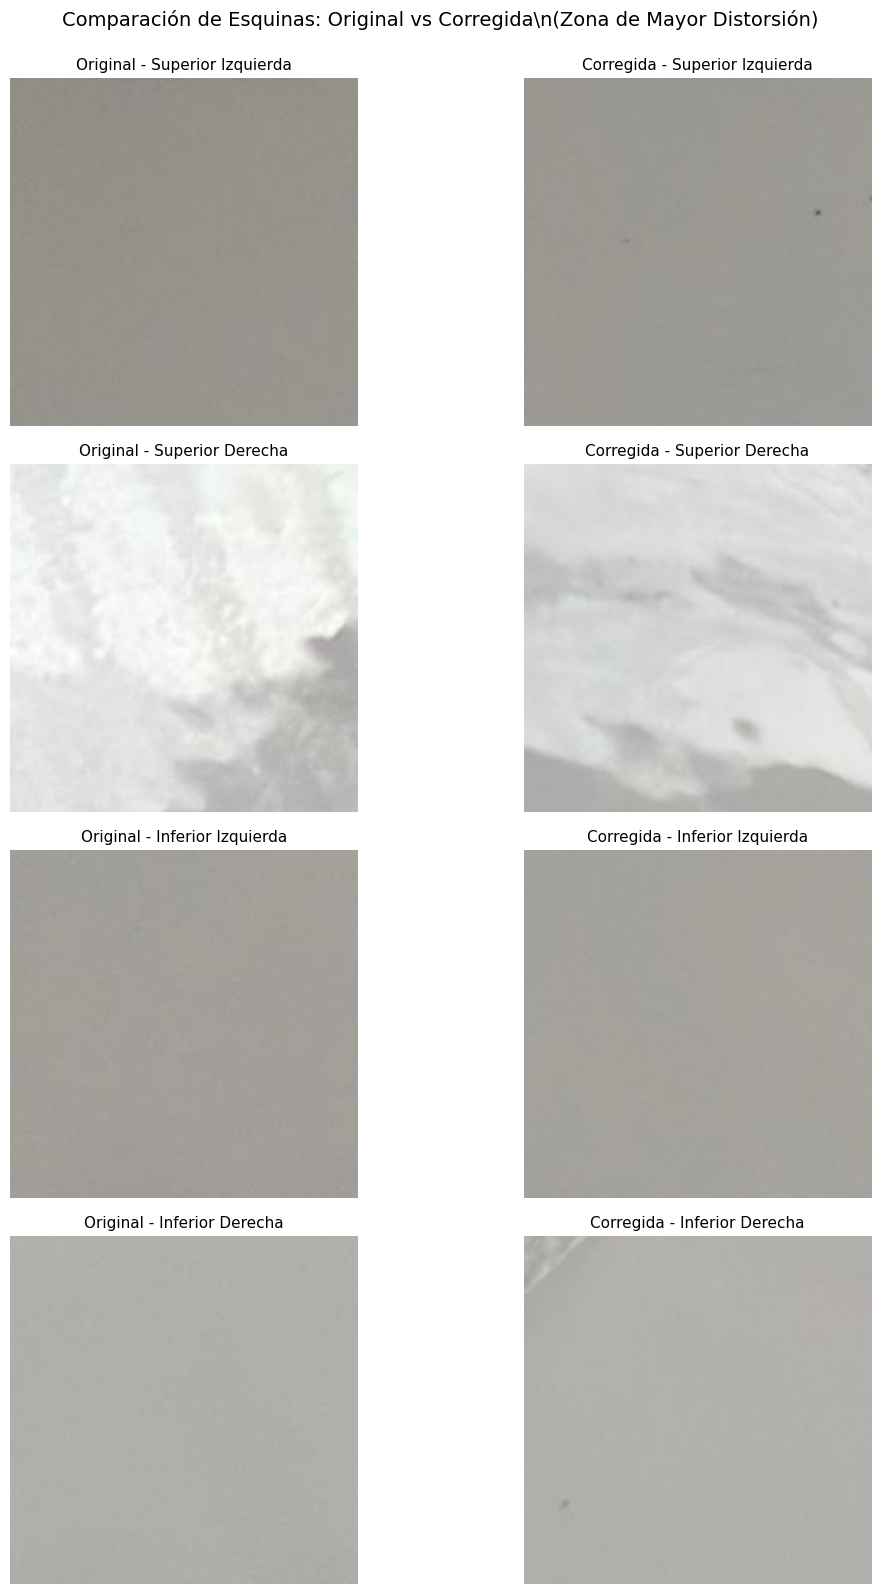

In [18]:
# Mostrar zoom en las esquinas de la primera imagen
if len(undistorted_images) > 0:
    img_path, original, undistorted = undistorted_images[0]
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    undistorted_rgb = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)
    
    # Definir regiones de las esquinas (200x200 píxeles)
    h_orig, w_orig = original_rgb.shape[:2]
    h_und, w_und = undistorted_rgb.shape[:2]
    crop_size = 200
    
    corners = {
        'Superior Izquierda': ((0, 0, crop_size, crop_size), (0, 0, crop_size, crop_size)),
        'Superior Derecha': ((w_orig-crop_size, 0, w_orig, crop_size), 
                             (w_und-crop_size, 0, w_und, crop_size)),
        'Inferior Izquierda': ((0, h_orig-crop_size, crop_size, h_orig), 
                               (0, h_und-crop_size, crop_size, h_und)),
        'Inferior Derecha': ((w_orig-crop_size, h_orig-crop_size, w_orig, h_orig),
                            (w_und-crop_size, h_und-crop_size, w_und, h_und))
    }
    
    fig, axes = plt.subplots(4, 2, figsize=(12, 16))
    
    for idx, (corner_name, ((x1o, y1o, x2o, y2o), (x1u, y1u, x2u, y2u))) in enumerate(corners.items()):
        # Original
        crop_orig = original_rgb[y1o:y2o, x1o:x2o]
        axes[idx, 0].imshow(crop_orig)
        axes[idx, 0].set_title(f'Original - {corner_name}', fontsize=11)
        axes[idx, 0].axis('off')
        
        # Corregida
        crop_und = undistorted_rgb[y1u:y2u, x1u:x2u]
        axes[idx, 1].imshow(crop_und)
        axes[idx, 1].set_title(f'Corregida - {corner_name}', fontsize=11)
        axes[idx, 1].axis('off')
    
    plt.suptitle('Comparación de Esquinas: Original vs Corregida\\n(Zona de Mayor Distorsión)', 
                 fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()

## 9. Análisis del Tipo de Distorsión

Analizamos el signo y magnitud de k1 para determinar el tipo de distorsión predominante.

In [19]:
print("ANÁLISIS DE DISTORSIÓN:")
print("="*60)
print(f"\nCoeficiente k1 = {k1:.6f}")
print(f"Coeficiente k2 = {k2:.6f}")
print(f"Coeficiente k3 = {k3:.6f}")

print("\nTipo de distorsión:")
if k1 < 0:
    print("  → DISTORSIÓN DE BARRIL (k1 < 0)")
    print("     Las líneas rectas se curvan hacia afuera")
    print("     Común en lentes gran angular y cámaras de teléfonos")
elif k1 > 0:
    print("  → DISTORSIÓN DE COJÍN (k1 > 0)")
    print("     Las líneas rectas se curvan hacia adentro")
    print("     Común en lentes telefoto")
else:
    print("  → Sin distorsión radial significativa")

print(f"\nMagnitud de la distorsión:")
print(f"  |k1| = {abs(k1):.6f}")
if abs(k1) < 0.05:
    print("  → Distorsión baja")
elif abs(k1) < 0.2:
    print("  → Distorsión moderada")
else:
    print("  → Distorsión alta")

print("\nDistorsión tangencial:")
print(f"  p1 = {p1:.6f}")
print(f"  p2 = {p2:.6f}")
if abs(p1) < 0.001 and abs(p2) < 0.001:
    print("  → Distorsión tangencial negligible")
else:
    print("  → Distorsión tangencial presente (desalineación del lente)")

print("\n" + "="*60)

ANÁLISIS DE DISTORSIÓN:

Coeficiente k1 = 0.177385
Coeficiente k2 = -0.976267
Coeficiente k3 = 1.343042

Tipo de distorsión:
  → DISTORSIÓN DE COJÍN (k1 > 0)
     Las líneas rectas se curvan hacia adentro
     Común en lentes telefoto

Magnitud de la distorsión:
  |k1| = 0.177385
  → Distorsión moderada

Distorsión tangencial:
  p1 = 0.001367
  p2 = 0.000697
  → Distorsión tangencial presente (desalineación del lente)



### 9.1 Visualización del Patrón de Distorsión

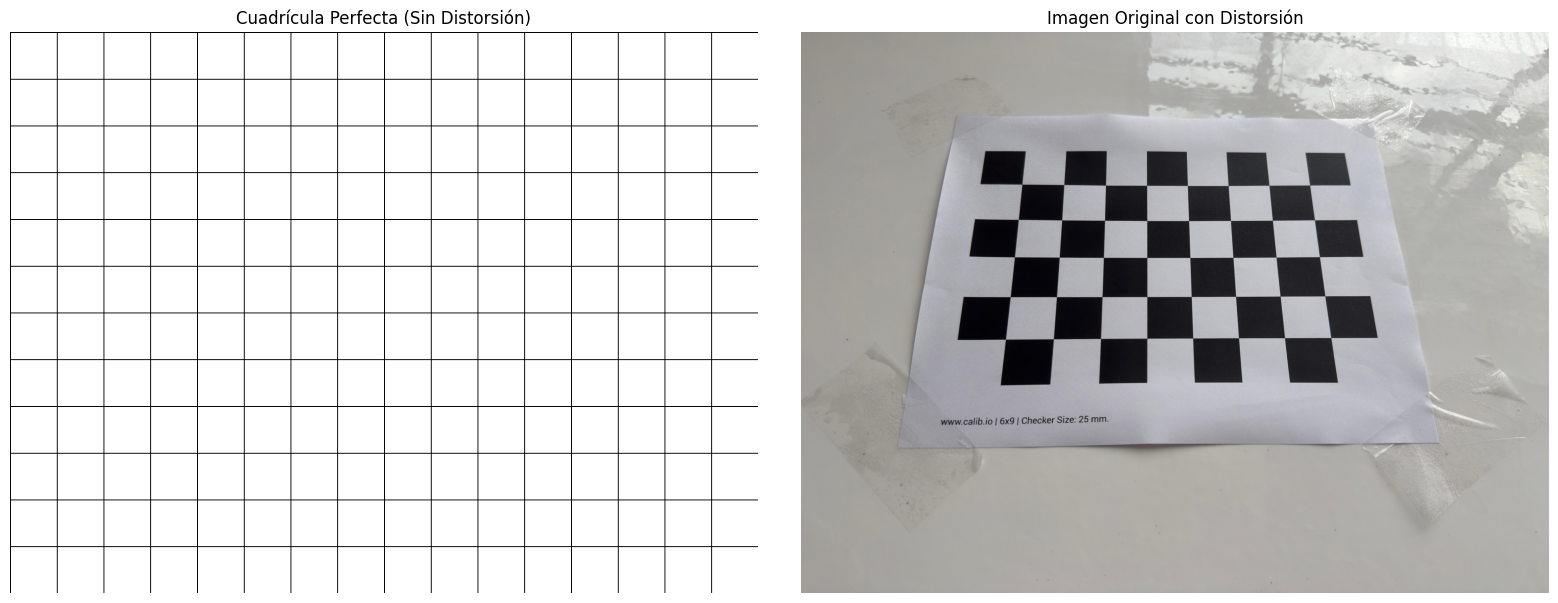

Nota: En la imagen original, las líneas rectas del tablero aparecen
      curvadas debido a la distorsión del lente. La calibración permite
      corregir este efecto.


In [20]:
# Crear una imagen con una cuadrícula para visualizar la distorsión
grid_img = np.zeros((600, 800, 3), dtype=np.uint8)
grid_img.fill(255)  # Fondo blanco

# Dibujar líneas verticales y horizontales
for i in range(0, 800, 50):
    cv2.line(grid_img, (i, 0), (i, 600), (0, 0, 0), 1)
for i in range(0, 600, 50):
    cv2.line(grid_img, (0, i), (800, i), (0, 0, 0), 1)

# Aplicar distorsión a la cuadrícula (simulación inversa)
# Para esto, necesitamos crear puntos y aplicar la transformación
h, w = grid_img.shape[:2]

# Simular cómo se vería la cuadrícula con distorsión
# (esto es conceptual, la distorsión real ya está en las imágenes)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cuadrícula perfecta (sin distorsión)
axes[0].imshow(cv2.cvtColor(grid_img, cv2.COLOR_BGR2RGB))
axes[0].set_title('Cuadrícula Perfecta (Sin Distorsión)', fontsize=12)
axes[0].axis('off')

# Para mostrar el efecto de distorsión, usamos una imagen real corregida
if len(undistorted_images) > 0:
    # Aplicar distorsión "inversa" para mostrar el efecto
    # (en la práctica, las imágenes originales ya tienen distorsión)
    img_path, original, _ = undistorted_images[0]
    axes[1].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Imagen Original con Distorsión', fontsize=12)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

print("Nota: En la imagen original, las líneas rectas del tablero aparecen")
print("      curvadas debido a la distorsión del lente. La calibración permite")
print("      corregir este efecto.")

## 10. Análisis de los Parámetros de la Cámara

### 10.1 Comparación de fx y fy (Distancias Focales)

In [21]:
print("ANÁLISIS DE DISTANCIAS FOCALES:")
print("="*60)
print(f"\nfx = {fx:.2f} píxeles")
print(f"fy = {fy:.2f} píxeles")
print(f"\nDiferencia: {abs(fx - fy):.2f} píxeles")
print(f"Porcentaje de diferencia: {abs(fx - fy) / max(fx, fy) * 100:.2f}%")

if abs(fx - fy) < 1:
    print("\n✓ fx ≈ fy: Los píxeles son aproximadamente cuadrados")
    print("  Esto es ideal y común en cámaras digitales modernas")
elif abs(fx - fy) < 10:
    print("\n⚠ fx y fy son ligeramente diferentes")
    print("  Razones posibles:")
    print("  - Píxeles no perfectamente cuadrados (aspect ratio)")
    print("  - Tolerancias de manufactura en el sensor")
    print("  - Compresión o procesamiento de imagen")
else:
    print("\n⚠ fx y fy tienen diferencia significativa")
    print("  Razones posibles:")
    print("  - Píxeles rectangulares en el sensor")
    print("  - Distorsión anisotrópica del lente")
    print("  - Error en la calibración")

print("\n" + "="*60)

ANÁLISIS DE DISTANCIAS FOCALES:

fx = 2872.57 píxeles
fy = 2855.90 píxeles

Diferencia: 16.67 píxeles
Porcentaje de diferencia: 0.58%

⚠ fx y fy tienen diferencia significativa
  Razones posibles:
  - Píxeles rectangulares en el sensor
  - Distorsión anisotrópica del lente
  - Error en la calibración



### 10.2 Análisis del Punto Principal (cx, cy)

In [22]:
# Calcular el centro geométrico de la imagen
img_width, img_height = img_shape
center_x = img_width / 2
center_y = img_height / 2

print("ANÁLISIS DEL PUNTO PRINCIPAL:")
print("="*60)
print(f"\nDimensiones de la imagen: {img_width} x {img_height} píxeles")
print(f"\nCentro geométrico de la imagen:")
print(f"  Centro X = {center_x:.2f} píxeles")
print(f"  Centro Y = {center_y:.2f} píxeles")
print(f"\nPunto principal calibrado (centro óptico):")
print(f"  cx = {cx:.2f} píxeles")
print(f"  cy = {cy:.2f} píxeles")
print(f"\nDesviación del centro:")
print(f"  Δx = {abs(cx - center_x):.2f} píxeles ({abs(cx - center_x) / img_width * 100:.2f}% del ancho)")
print(f"  Δy = {abs(cy - center_y):.2f} píxeles ({abs(cy - center_y) / img_height * 100:.2f}% del alto)")

# Distancia euclidiana del centro
distance_from_center = np.sqrt((cx - center_x)**2 + (cy - center_y)**2)
print(f"\nDistancia desde el centro: {distance_from_center:.2f} píxeles")

if distance_from_center < 10:
    print("\n✓ El punto principal está muy cerca del centro de la imagen")
    print("  Esto es ideal y esperado en cámaras bien calibradas")
elif distance_from_center < 50:
    print("\n⚠ El punto principal está ligeramente desplazado del centro")
    print("  Razones posibles:")
    print("  - Desalineación menor del lente")
    print("  - Sensor no perfectamente centrado")
    print("  - Recorte o procesamiento de la imagen")
else:
    print("\n⚠ El punto principal está significativamente desplazado")
    print("  Razones posibles:")
    print("  - Imagen recortada o con aspect ratio modificado")
    print("  - Desalineación del lente")
    print("  - Error en la calibración")

print("\n" + "="*60)

ANÁLISIS DEL PUNTO PRINCIPAL:

Dimensiones de la imagen: 4160 x 3120 píxeles

Centro geométrico de la imagen:
  Centro X = 2080.00 píxeles
  Centro Y = 1560.00 píxeles

Punto principal calibrado (centro óptico):
  cx = 2004.53 píxeles
  cy = 1551.35 píxeles

Desviación del centro:
  Δx = 75.47 píxeles (1.81% del ancho)
  Δy = 8.65 píxeles (0.28% del alto)

Distancia desde el centro: 75.96 píxeles

⚠ El punto principal está significativamente desplazado
  Razones posibles:
  - Imagen recortada o con aspect ratio modificado
  - Desalineación del lente
  - Error en la calibración



### 10.3 Visualización del Punto Principal

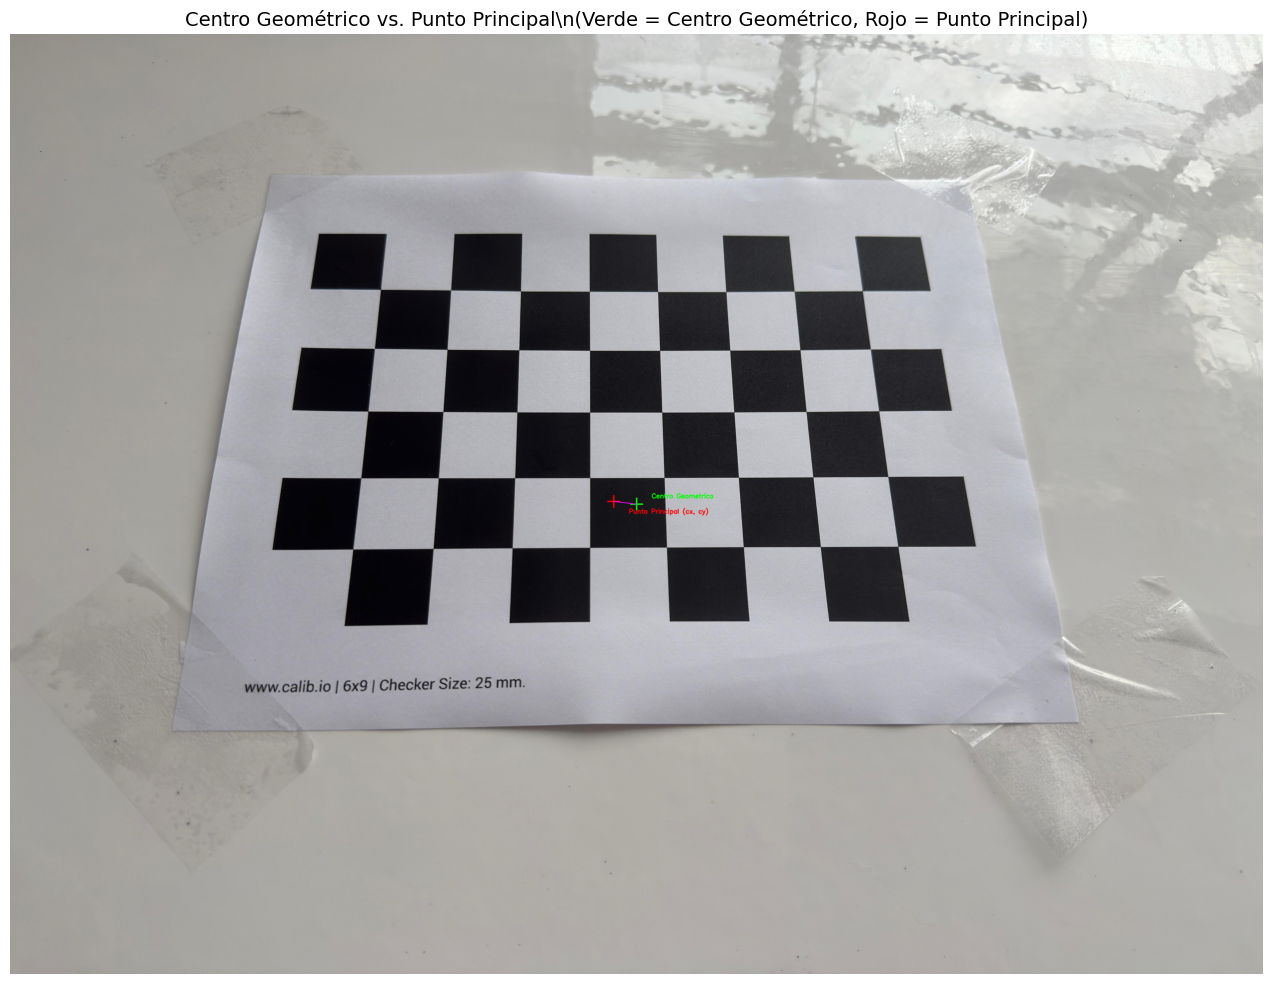

In [23]:
# Visualizar el punto principal en una imagen
if len(images) > 0:
    img = cv2.imread(images[0])
    img_vis = img.copy()
    
    # Dibujar el centro geométrico (verde)
    cv2.drawMarker(img_vis, (int(center_x), int(center_y)), (0, 255, 0), 
                   cv2.MARKER_CROSS, 40, 3)
    
    # Dibujar el punto principal (rojo)
    cv2.drawMarker(img_vis, (int(cx), int(cy)), (0, 0, 255), 
                   cv2.MARKER_CROSS, 40, 3)
    
    # Dibujar línea conectando ambos puntos
    cv2.line(img_vis, (int(center_x), int(center_y)), (int(cx), int(cy)), 
             (255, 0, 255), 2)
    
    # Añadir texto
    cv2.putText(img_vis, 'Centro Geometrico', (int(center_x) + 50, int(center_y) - 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    cv2.putText(img_vis, 'Punto Principal (cx, cy)', (int(cx) + 50, int(cy) + 40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.title('Centro Geométrico vs. Punto Principal\\n(Verde = Centro Geométrico, Rojo = Punto Principal)', 
              fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## 11. Resumen y Conclusiones

In [24]:
print("="*70)
print(" "*20 + "RESUMEN DE CALIBRACIÓN")
print("="*70)

print("\n1. DATOS GENERALES:")
print(f"   - Imágenes procesadas: {len(objpoints)} de {len(images)}")
print(f"   - Dimensiones de imagen: {img_width} x {img_height} píxeles")
print(f"   - Patrón de tablero: {CHESSBOARD_SIZE[0]}x{CHESSBOARD_SIZE[1]} esquinas")

print("\n2. MATRIZ DE CÁMARA K:")
print(f"   fx = {fx:.2f} píxeles")
print(f"   fy = {fy:.2f} píxeles")
print(f"   cx = {cx:.2f} píxeles")
print(f"   cy = {cy:.2f} píxeles")

print("\n3. COEFICIENTES DE DISTORSIÓN:")
print(f"   k1 = {k1:.6f}")
print(f"   k2 = {k2:.6f}")
print(f"   p1 = {p1:.6f}")
print(f"   p2 = {p2:.6f}")
print(f"   k3 = {k3:.6f}")

print("\n4. CALIDAD DE CALIBRACIÓN:")
print(f"   Error RMS = {ret:.4f} píxeles")
if ret < 0.5:
    print("   Estado: ✓ Excelente")
elif ret < 1.0:
    print("   Estado: ✓ Buena")
else:
    print("   Estado: ⚠ Aceptable")

print("\n5. ANÁLISIS:")
print(f"   Tipo de distorsión: {'Barril' if k1 < 0 else 'Cojín' if k1 > 0 else 'Mínima'}")
print(f"   Magnitud de k1: {abs(k1):.6f}")
print(f"   Similitud fx/fy: {abs(fx-fy):.2f} píxeles de diferencia ({abs(fx-fy)/max(fx,fy)*100:.2f}%)")
print(f"   Desviación del punto principal: {distance_from_center:.2f} píxeles")

print("\n6. INTERPRETACIÓN:")
if k1 < 0:
    print("   • La cámara presenta distorsión de barril (típica en gran angular)")
else:
    print("   • La cámara presenta distorsión de cojín (típica en telefoto)")

if abs(fx - fy) < 1:
    print("   • Los píxeles son aproximadamente cuadrados (ideal)")
else:
    print("   • Hay una ligera diferencia entre fx y fy")

if distance_from_center < 10:
    print("   • El punto principal está bien centrado")
else:
    print("   • El punto principal está ligeramente desplazado del centro")

print("\n" + "="*70)
print("Calibración completada exitosamente.")
print("Los parámetros pueden usarse para corregir distorsión y reconstrucción 3D.")
print("="*70)

                    RESUMEN DE CALIBRACIÓN

1. DATOS GENERALES:
   - Imágenes procesadas: 6 de 10
   - Dimensiones de imagen: 4160 x 3120 píxeles
   - Patrón de tablero: 8x5 esquinas

2. MATRIZ DE CÁMARA K:
   fx = 2872.57 píxeles
   fy = 2855.90 píxeles
   cx = 2004.53 píxeles
   cy = 1551.35 píxeles

3. COEFICIENTES DE DISTORSIÓN:
   k1 = 0.177385
   k2 = -0.976267
   p1 = 0.001367
   p2 = 0.000697
   k3 = 1.343042

4. CALIDAD DE CALIBRACIÓN:
   Error RMS = 1.8039 píxeles
   Estado: ⚠ Aceptable

5. ANÁLISIS:
   Tipo de distorsión: Cojín
   Magnitud de k1: 0.177385
   Similitud fx/fy: 16.67 píxeles de diferencia (0.58%)
   Desviación del punto principal: 75.96 píxeles

6. INTERPRETACIÓN:
   • La cámara presenta distorsión de cojín (típica en telefoto)
   • Hay una ligera diferencia entre fx y fy
   • El punto principal está ligeramente desplazado del centro

Calibración completada exitosamente.
Los parámetros pueden usarse para corregir distorsión y reconstrucción 3D.
